# 7.2 Monte Carlo for sampling

In [8]:
# The usual notebook preferences
%config InlineBackend.figure_format = 'svg'
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from helper_functions import *
set_notebook_preferences()

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In the previous section we showed how Monte Carlo methods can be used to evaluate integrals, including probability weighted integrals. MC allowed us to approximate otherwise intractable integrals. In this section we present MC methods which allow us to sample from otherwise intractable probability distributions. We will start by looking at methods for tackling analytically tractable distributions and will then move to the intractable ones.

## Exact sampling from distributions

Suppose we have a distribution with PDF $p(x)$ and CDF $h(x)$. Let's also assume $h(x)$ has a closed form inverse, $h^{-1}(x)$. There exists a method to sample exactly $-$ that is without approximations or discretisations $-$ from this distribution, namely by sampling from the uniform distribution $u^\star \sim \mathcal{U}[0, 1]$ and then computing $s^\star = h^{-1}(a^\star)$. The variable $s^\star$ is then distributed according to the desired probability distribution. Let's apply this example to the Lorentzian distribution:

\begin{align}
p(x) = \frac{a}{\pi}\frac{1}{\alpha^2 + x^2}
\end{align}

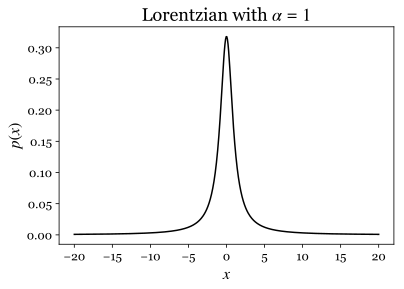

In [13]:
alpha = 1
xs = np.linspace(-20, 20, 500)
plt.plot(xs, (1/np.pi)/(alpha**2 + xs**2), color = 'black')
beautify_plot({"title": r"Lorentzian with $\alpha$ = $" + str(alpha) + "$", "x":"$x$", "y":"$p(x)$"})
plt.show()

The number $\alpha$ is the lengthscale of the distribution, controling how wide the distribution is. The PDF $p(x)$ given here is normalised and it can be shown that the corresponding CDF is:

\begin{align}
h(x) = \int_{- \infty}^x p(x') dx' &= \int_{- \infty}^x \frac{a}{\pi}\frac{1}{a^2 + x'^2}  dx'\\
~\\
&= \frac{1}{\pi}\text{arctan}\bigg(\frac{x}{\alpha}\bigg) + \frac{1}{2}
\end{align}

This can be rearranged to give $h^{-1}(x)$

\begin{align}
h^{-1}(x) = \alpha~\text{tan}\bigg(\pi x - \frac{\pi}{2}\bigg)
\end{align}

We are now at a position to sample from the Lorentzian with the method mentioned above.

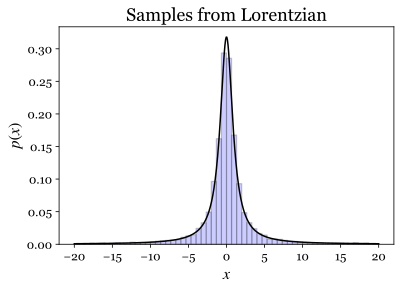

In [14]:
alpha = 1
cdf_samples = np.random.rand(10000) # draw random samples from uniform distribution
pdf_samples = alpha*np.tan(np.pi*cdf_samples - np.pi/2) # calculate values using inverse CDF
pdf_samples = pdf_samples[np.where(abs(pdf_samples) < 20)[0]] # reject points far from 0 for plotting purposes
plt.hist(pdf_samples, range = (-20, 20), bins = 60, color = 'blue',
         alpha = 0.2, edgecolor='black', linewidth = 1.2, normed = True) # plot normalised bins
xs = np.linspace(-20, 20, 500)
plt.plot(xs, (alpha/np.pi)/(alpha**2 + xs**2), color = 'black')
beautify_plot({"title": r"Samples from Lorentzian", "x":"$x$", "y":"$p(x)$"})
plt.show()

The histogram of the samples follows the PDF quite closely. You can experiment with the value of $\alpha$ to see its effect on the distribution and samples. You might notice that using large $\alpha$ results in the heights of the curve and the histogram to disagree, because lots of samples are falling outside the plotting range, which messes up the normalisation of bar heights $-$ this is purely a plotting artifact. What happens however if we cannot find the inverse of the CDF, or the CDF itself? We need some different sampling method than that outlined here. The two alternatives we will discuss here are rejection sampling, which is really a variant of the method we previously used to evaluate integrals, and importance sampling, which is motivated naturally through importance sampling.

## Rejection sampling

Suppose we wish to sample from a distribution with PDF $p(x)$, of which the CDF we cannot or want to avoid solving for. Rejection sampling is a method which enables us to do so. It uses the fact that points $(x, y)$ which are uniformly distributed in the area under the PDF curve have $x$ which follows the desired distribution. Showing this is straighforward: let $q(x, y)$ be a distribution of which the samples are uniformly distributed in the area under $p(x)$. For a point $(x, y)$ drawn from $q$, the distribution of its $x$ coordinate is obtained by marginalising over $y$: $q(x) = \int q(x, y) dy$. But this is simply the height of the PDF at $x$, i.e. $q(x) = p(x)$. Therefore, sampling a point from the area under the PDF gives a distribution of $x$'s which follows $p(x)$. In fact, $p(x)$ does not even need to be a normalised distribution, because $y$ is integrated over so rescaling it has no effect on this method.

How do we sample from the area under the curve however? One approach would be to sample uniformly from a rectangle enclosing the main part of the distribution. Then, if the point lies under the PDF we keep it as a sample, otherwise we reject it and repeat until we get one which lies under the curve. This process is very similar to that used previously when evaluating integrals $-$ let's see what it would look like for sampling from the challenging integrand seen previously

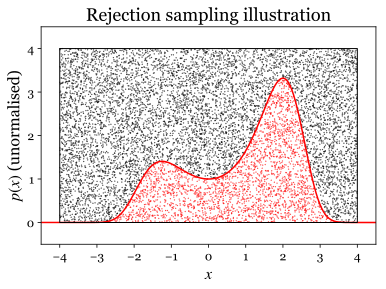

Fraction of points kept = 0.2574


In [71]:
max_x, min_x, max_y, min_y = 4, -4, 4, 0
no_samples = 10**4
samples = np.random.uniform([min_x, min_y], [max_x, max_y], (no_samples, 2))

x_ = samples[:, 0]
y_ = np.exp(-(0.1*x_**4 - 0.1*x_**3 - 0.5*x_**2))
x = np.linspace(-5, 5, 200)
y = np.exp(-(0.1*x**4 - 0.1*x**3 - 0.5*x**2))

colors = np.array(['black', 'red'])[(samples[:, 1] <= y_)*1]
plt.scatter(samples[:, 0], samples[:, 1], s = 0.1, color = colors)
plt.plot(x, y, color = 'red')
plt.xlim([min_x-0.5, max_x+0.5]), plt.ylim([min_y-0.5, max_y+0.5])
rect = patches.Rectangle((-4, 0), 8, 4, linewidth = 1, edgecolor='black', facecolor='none', zorder = 5)
plt.gca().add_patch(rect)
beautify_plot({"title": "Rejection sampling illustration", "x":"$x$", "y":"$p(x)$ (unormalised)"})

plt.show()
samps_kept = len(np.where(samples[:, 1] <= y_)[0])
print("Fraction of points kept = {}".format(samps_kept/no_samples))

This method has two shortcomings however:

1. If the distribution is heavy-tailed, i.e. has significant probability density over a long range of $x$, using a box to cut it off will yield poor results as the tails will never be sampled.

2. It is quite inefficient. In this example roughly $3/4$ of the samples are rejected, meaning that on average we must draw $\approx 4$ samples to get one we will keep.

Luckily we can kill two birds with one stone and fix both issues through a single adaptation. Instead of sampling uniformly from a rectangle area, we can use another analytically tractable distribution as sampling area, which we can scale vertically to enclose the first if required as illustrated below.

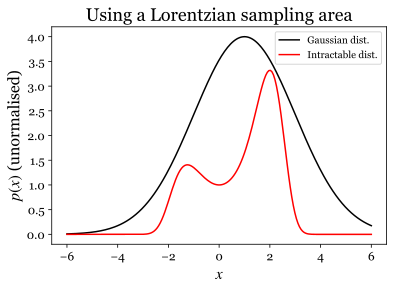

In [63]:
x_ = np.linspace(-6, 6, 200)
p = np.exp(-(0.1*x_**4 - 0.1*x_**3 - 0.5*x_**2))
mu, sig, height = 1, 2, 4
gaussian = height*np.exp(-1/(2*sig**2)*(x_ - mu)**2)

plt.plot(x_, gaussian, 'black', label = 'Gaussian dist.')
plt.plot(x_, p, 'red', label = 'Intractable dist.')
plt.gca().legend()
beautify_plot({"title": r"Using a Lorentzian sampling area", "x":"$x$", "y":"$p(x)$ (unormalised)"})
plt.show()

We can adapt the rejection sampling method to:

1. Choose a tractable PDF $q(x)$ and a constant $M$ such that $Mq(x) > p(x)$ everywhere.
2. Sample $x_i \sim q(x)$, and $u_i \sim \mathcal{U}[0, 1]$.
3. If $uMq(x_i) < p(x_i)$, i.e. the sample lies below the PDF we seek to sample, keep it. Otherwise discard it and repeat from step 2.

It is easy to convince yourself that this process consists of sampling uniformly from the area under the (scaled) tractable distribution and then keeping the samples which lie under the intractable one. Let's see what this method looks like in practice, approximating the challenging integrand above by an appropriately scaled Lorentzian.

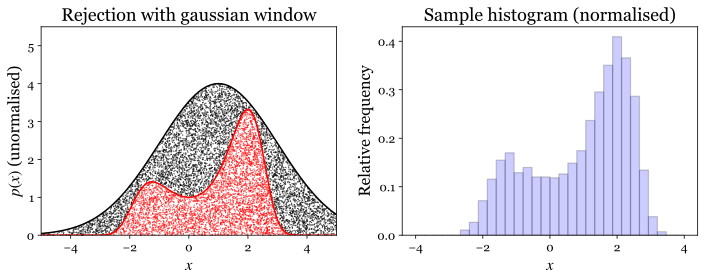

Fraction of points kept = 0.4214


In [70]:
no_samples = 10**4 # number of samples (some will be rejected)
mu, sig, M = 1, 2, 4
gauss_samps = np.random.normal(loc = 1, scale = 2, size = (no_samples,))
Mq = M*np.exp(-1/(2*sig**2)*(gauss_samps - mu)**2) # scaled height of gaussian at sample locations
p = np.exp(-(0.1*gauss_samps**4 - 0.1*gauss_samps**3 - 0.5*gauss_samps**2)) # height of PDF at sample locations
u = np.random.rand(no_samples) # random samples between [0, 1] to do rejection
samples_kept = gauss_samps[np.where(Mq*u < p)] # reject points under PDF


plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
colors = np.array(['black', 'red'])[(Mq*u < p)*1]
plt.scatter(gauss_samps, Mq*u, s = 0.1, color = colors)
plt.plot(x_, y_lorentz, 'black')
plt.plot(x_, y_prob, 'red')
beautify_plot({"title": "Rejection with gaussian window", "x":"$x$", "y":"$p(x)$ (unormalised)"})
plt.xlim([-5, 5]), plt.ylim([0, 5.5])

plt.subplot(1, 2, 2)
plt.hist(samples_kept, range = (-4, 4), bins = 30, color = 'blue',
         alpha = 0.2, edgecolor='black', linewidth = 1.2, normed = True)
beautify_plot({"title": "Sample histogram (normalised)", "x":"$x$", "y":"Relative frequency"})
plt.tight_layout()
plt.show()

print("Fraction of points kept = {}".format(samples_kept.shape[0]/no_samples))

Using this gaussian window we have increased the fraction of retained points from $\approx 0.25$ to $\approx 0.42$,  and have avoided the problem of cutting off the tails of the distribution, so long as $p(x) < Mq(x)$ everywhere. In general, picking the enveloping distribution to match the shape of the intractable one as close as possible will minimise the fraction of rejected points and thus the number of trials required to obtain a sample which we keep. Once we obtain the samples we can evaluate quantities such as probability-weighted integrals of the form $\int p(x)f(x)dx$ further down the line. There are two issues related to this rejection sampling approach however:

1. Rejecting so many points seems somewhat wasteful and we would like to do better.

2. Rejection sampling requires that we pick $M$ and $q(x)$ to satisfy the constraint $p(x) < Mq(x)$. In some cases we may not be able to find a distribution which satisfies this, and we certaintly want to avoid making these selections manually.

The second issue points to the method of importance sampling, a method for evaluating probability weighted integrals, in which no points are rejected and all of them contribute to the integral through a weighted sum.

## Importance sampling

Suppose we wish to evaluate the probability weighted integral $\int p(x)f(x)dx$ where $p(x)$ is a probability distribution and $f(x)$ some arbitrary function. For the moment we assume $p(x)$ is normalised and will later on address how to deal the case where it is unormalised. If $p(x)$ is intractable, we cannot sample directly from it, so to use the MC approach

\begin{align}
\int p(x)f(x) dx \approx \frac{1}{N}\sum^N_{n = 1}f(x_n), \text{ where } x_n \sim p(x)
\end{align}

we could need to implement rejection sampling. To avoid wasteful rejection and having to manually pick an appropriate enveloping distribution $q(x)$ and scaling factor $M$, we can use the alternative approach of importance sampling:

\begin{align}
\int p(x)f(x) dx = \int \frac{p(x)}{q(x)}f(x) q(x) dx = \frac{1}{N}\sum^N_{n = 1}\frac{p(x)}{q(x)}f(x_n), \text{ where } x_n \sim q(x)
\end{align}

Here there are no constraints on our choice of $q(x)$ as in rejection sampling, which we can choose as we like. As an example, let us define:

\begin{align}
p(x) &= \frac{1}{A} e^{-\frac{1}{10}x^4 - \frac{1}{10}x^3 - \frac{1}{2}x^2}, \text{ the challenging integrand from before,}\\
~\\
f(x) &= x^2\\
~\\
q(x) &= \mathcal{N}(x; 0, 4)\\
~\\
\end{align}

where $A \approx 8.4339$ is the normalising constant for $p(x)$. Let's have a look at an implementation of importance sampling for this example:

In [119]:
no_samples = 10**5
mean, sig = 0, 2
gauss_samples = np.random.normal(loc = mean, scale = sig, size = (no_samples,))
q = 1/(2*np.pi*sig**2)**0.5*np.exp(-1/(2*sig**2)*(gauss_samples - mean)**2)
p = np.exp(-(0.1*gauss_samples**4 - 0.1*gauss_samples**3 - 0.5*gauss_samples**2))/8.4339

w = p/q

print("Importance sampling approximation to integral:", np.sum((w*gauss_samples**2).mean().round(3)))

Importance sampling approximation to integral: 2.767


As usual, we can repeat this process to see the effect of the number of samples on our approximation by making several estimates for it and also looping over the number of samples $N$:

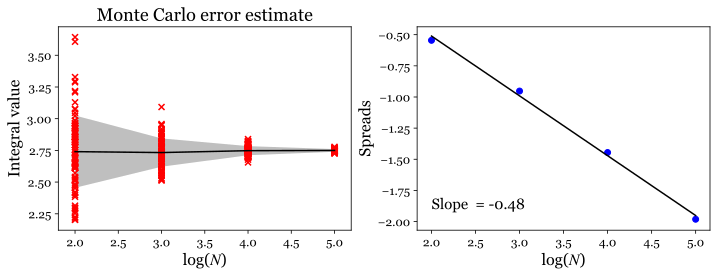

In [122]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 100 # number of MC trials for each sample size
mean, sig = 0, 2

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        mean, sig = 1, 2
        gauss_samples = np.random.normal(loc = mean, scale = sig, size = (N,))
        q = 1/(2*np.pi*sig**2)**0.5*np.exp(-1/(2*sig**2)*(gauss_samples - mean)**2)
        p = np.exp(-(0.1*gauss_samples**4 - 0.1*gauss_samples**3 - 0.5*gauss_samples**2))/8.4339

        w = p/q
        
        estimates[-1].append(np.sum((w*gauss_samples**2).mean().round(3)))
    
estimates = np.array(estimates)
means, stdevs = estimates.mean(axis = 1), estimates.var(axis = 1)**0.5

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log10(sample_sizes), means, color = 'black')
plt.fill_between(np.log10(sample_sizes), means + stdevs, means - stdevs, facecolor = 'grey', alpha = 0.5)
plt.scatter((np.array([np.log10(sample_sizes)]*trials_per_size).T).flatten(),
            estimates.flatten(), marker = 'x', color = 'red')
beautify_plot({"title": "Monte Carlo error estimate", "x":"log($N$)", "y":"Integral value"})

plt.subplot(1, 2, 2)
plt.scatter(np.log10(sample_sizes), np.log10(stdevs), marker = 'o', color = 'blue')
beautify_plot({"title": "", "x":"log($N$)", "y":"Spreads"})
slope, intercept = stats.linregress(np.log10(sample_sizes), np.log10(stdevs))[:2]
plt.plot(np.linspace(2, 5, 100), slope*np.linspace(2, 5, 100) + intercept, color = 'black')
plt.text(2, -1.9, s = 'Slope  = {}'.format(slope.round(3)), fontsize = 15)

plt.tight_layout()
plt.show()

We observe the usual linear log-log plot of the spread in the MC estimates against the number of samples per estimate $N$. As a final sanity check let's also evaluate the integral using the numerical integrator ```integrate.quad```.

In [99]:
import scipy.integrate as integrate

integral = integrate.quad(lambda x: x**2*np.exp(-(0.1*x**4 - 0.1*x**3 - 0.5*x**2))/8.4339, -np.inf, np.inf)[0]
print("Approximation of integral using numerical method:", round(integral, 3))

Approximation of integral using numerical method: 2.751


How may we go about the case where $p(x)$ is unormalised? To make this explicit, we denote the unormalised version of $p(x)$ as $\widetilde{p}(x)$ and proceed as before:

\begin{align}
\int p(x)f(x) dx = \int \frac{1}{Z_p}\widetilde{p}(x)f(x) dx \approx \frac{1}{Z_p}\frac{1}{N}\sum^N_{n = 1}\frac{\widetilde{p}(x)}{q(x_n)}f(x_n), \text{ where } x_n \sim q(x), \text{ and } Z_p = \int \widetilde{p}(x_n) dx
\end{align}

Denoting $w_n = \widetilde{p}(x_n)/q(x_n)$:

\begin{align}
\int p(x)f(x) dx &\approx \frac{1}{Z_p}\frac{1}{N}\sum^N_{n = 1}w_nf(x_n)\\
~\\
&= \frac{1}{N}\sum^N_{n = 1}\frac{w_nf(x_n)}{\frac{1}{N}\sum^N_{n' = 1} w_n}
\end{align}

where we have used the fact that we can approximate the normalising constant through

\begin{align}
Z_p = \int \widetilde{p}(x) dx = \int \frac{\widetilde{p}(x)}{q(x)} q(x) dx \approx \frac{1}{N}\sum^N_{n = 1}w_nf(x_n)\text{ where } x_n \sim q(x)
\end{align}

Let's implement this for the example seen before:

In [114]:
no_samples = 10**5
mean, sig = 0, 2
gauss_samples = np.random.normal(loc = mean, scale = sig, size = (no_samples,))
q = 1/(2*np.pi*sig**2)**0.5*np.exp(-1/(2*sig**2)*(gauss_samples - mean)**2)
p_ = np.exp(-(0.1*gauss_samples**4 - 0.1*gauss_samples**3 - 0.5*gauss_samples**2))

w = p_/q
w_sum = w.sum()

print("Importance sampling approximation to integral:", np.sum((w*gauss_samples**2/w_sum)).round(3))

Importance sampling approximation to integral: 2.749


Importance sampling gives a reasonable answer here. There is however a subtlety here which we have looked over: repeating the process with a mean of $-5$ and standard deviation of $1$ for $q$ (which is a gaussian in this example) we obtain significantly different results:

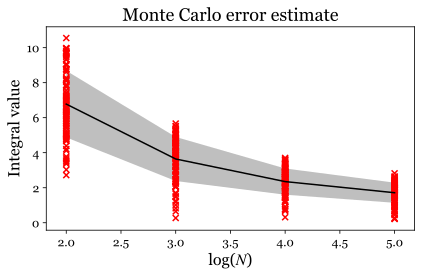

In [152]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 100 # number of MC trials for each sample size
mean, sig = -5, 1

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        gauss_samples = np.random.normal(loc = mean, scale = sig, size = (N,))
        q = 1/(2*np.pi*sig**2)**0.5*np.exp(-1/(2*sig**2)*(gauss_samples - mean)**2)
        p_ = np.exp(-(0.1*gauss_samples**4 - 0.1*gauss_samples**3 - 0.5*gauss_samples**2))

        w = p_/q
        w_sum = w.sum()
        
        estimates[-1].append(np.sum((w*gauss_samples**2/w_sum)))
    
estimates = np.array(estimates)
means, stdevs = estimates.mean(axis = 1), estimates.var(axis = 1)**0.5

plt.plot(np.log10(sample_sizes), means, color = 'black')
plt.fill_between(np.log10(sample_sizes), means + stdevs, means - stdevs, facecolor = 'grey', alpha = 0.5)
plt.scatter((np.array([np.log10(sample_sizes)]*trials_per_size).T).flatten(),
            estimates.flatten(), marker = 'x', color = 'red')
beautify_plot({"title": "Monte Carlo error estimate", "x":"log($N$)", "y":"Integral value"})

plt.tight_layout()
plt.show()

We see that for small $N$, the estimate mean is much higher than the actual value. You can experiment with the mean and standard deviation of the approximating gaussian to see its effect on the integral estimate. You should observe that the worst estimates occur for a narrow gaussian which is significantly displaced from the region in which $\widetilde{p}(x)$ places its mass. Does the same effect occur for the normalised case? Go back to the normalised example and experiment with the mean and standard deviation of the gaussian $-$ you will observe that the estimate mean is unaffected, however the spread of different estimates for given $N$ may change. Why is the unormalised estimator biased but the normalised one is not?

The reason for this is our estimate for $Z_p$ is calculated using the same set of coefficients as those used to evaluate the Monte Carlo sum. **Should add a detailed explanation for this**

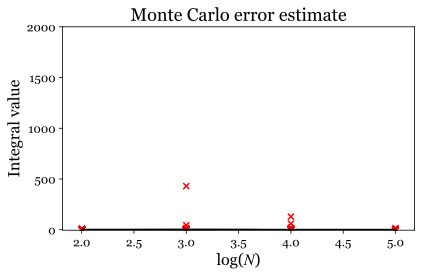

In [158]:
sample_sizes = np.array([10**2, 10**3, 10**4, 10**5]) # number of samples N to try out
trials_per_size = 1000 # number of MC trials for each sample size
mean, sig = -2, 0.5

estimates = []
for N in sample_sizes:
    
    estimates.append([])
    for i in range(trials_per_size):
        
        gauss_samples = np.random.normal(loc = mean, scale = sig, size = (N,))
        q = 1/(2*np.pi*sig**2)**0.5*np.exp(-1/(2*sig**2)*(gauss_samples - mean)**2)
        p_ = np.exp(-(0.1*gauss_samples**4 - 0.1*gauss_samples**3 - 0.5*gauss_samples**2))
        w = p_/q
        w_sum = w.sum()
        
        gauss_samples = np.random.normal(loc = mean, scale = sig, size = (N,))
        q = 1/(2*np.pi*sig**2)**0.5*np.exp(-1/(2*sig**2)*(gauss_samples - mean)**2)
        p_ = np.exp(-(0.1*gauss_samples**4 - 0.1*gauss_samples**3 - 0.5*gauss_samples**2))

        w = p_/q
        
        estimates[-1].append(np.sum((w*gauss_samples**2/w_sum)))
    
estimates = np.array(estimates)
means, stdevs = estimates.mean(axis = 1), estimates.var(axis = 1)**0.5

plt.plot(np.log10(sample_sizes), means, color = 'black')
plt.fill_between(np.log10(sample_sizes), means + stdevs, means - stdevs, facecolor = 'grey', alpha = 0.5)
plt.scatter((np.array([np.log10(sample_sizes)]*trials_per_size).T).flatten(),
            estimates.flatten(), marker = 'x', color = 'red')
beautify_plot({"title": "Monte Carlo error estimate", "x":"log($N$)", "y":"Integral value"})
plt.ylim([-5, 2000])
plt.tight_layout()
plt.show()